In [16]:

import glob
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd

import itertools
from itertools import cycle
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import imageio
from sklearn.preprocessing import label_binarize
from collections import Counter

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split, KFold
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
label_data  = pd.read_csv("/home/muhlabws4/Belgeler/UFC101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt",
                       sep = " ",
                       header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()



,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [18]:
path=[]
for label in label_data.labels.values:
    path.append('/home/muhlabws4/Belgeler/UFC101/UCF101/UCF-101/'+label+"/")
path[0]

'/home/muhlabws4/Belgeler/UFC101/UCF101/UCF-101/ApplyEyeMakeup/'

In [19]:
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    video_reader = cv2.VideoCapture(video_path)
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count/sequence_length), 1)
    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break;
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        frames_list.append(frame)
    video_reader.release()
    return frames_list

In [20]:
import sys
import platform

print(platform.python_version())


3.9.17


In [6]:

import cv2
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

images, labels = load_video(path[81:])
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)

100%|█████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.30it/s]


In [22]:
import pandas as pd
train_data = pd.DataFrame({'Images': x_train, 'Labels': y_train})
train_data.to_csv('train_data.csv', index=False)

# Test verilerini kaydet
test_data = pd.DataFrame({'Images': x_test, 'Labels': y_test})
test_data.to_csv('test_data.csv', index=False)

ValueError: Per-column arrays must each be 1-dimensional

In [7]:
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((2371, 5, 60, 60, 3), (152, 5, 60, 60, 3), (2371,), (152,))

In [8]:
def videoview(index):
    fig = plt.figure(figsize=(32,8))
    for i,image in enumerate(images[index]):
        ax = plt.subplot(1,5,i+1)
        imshow(image[:,:,0])
        plt.title(label_data.labels.values[labels[index]+81],fontsize=21)

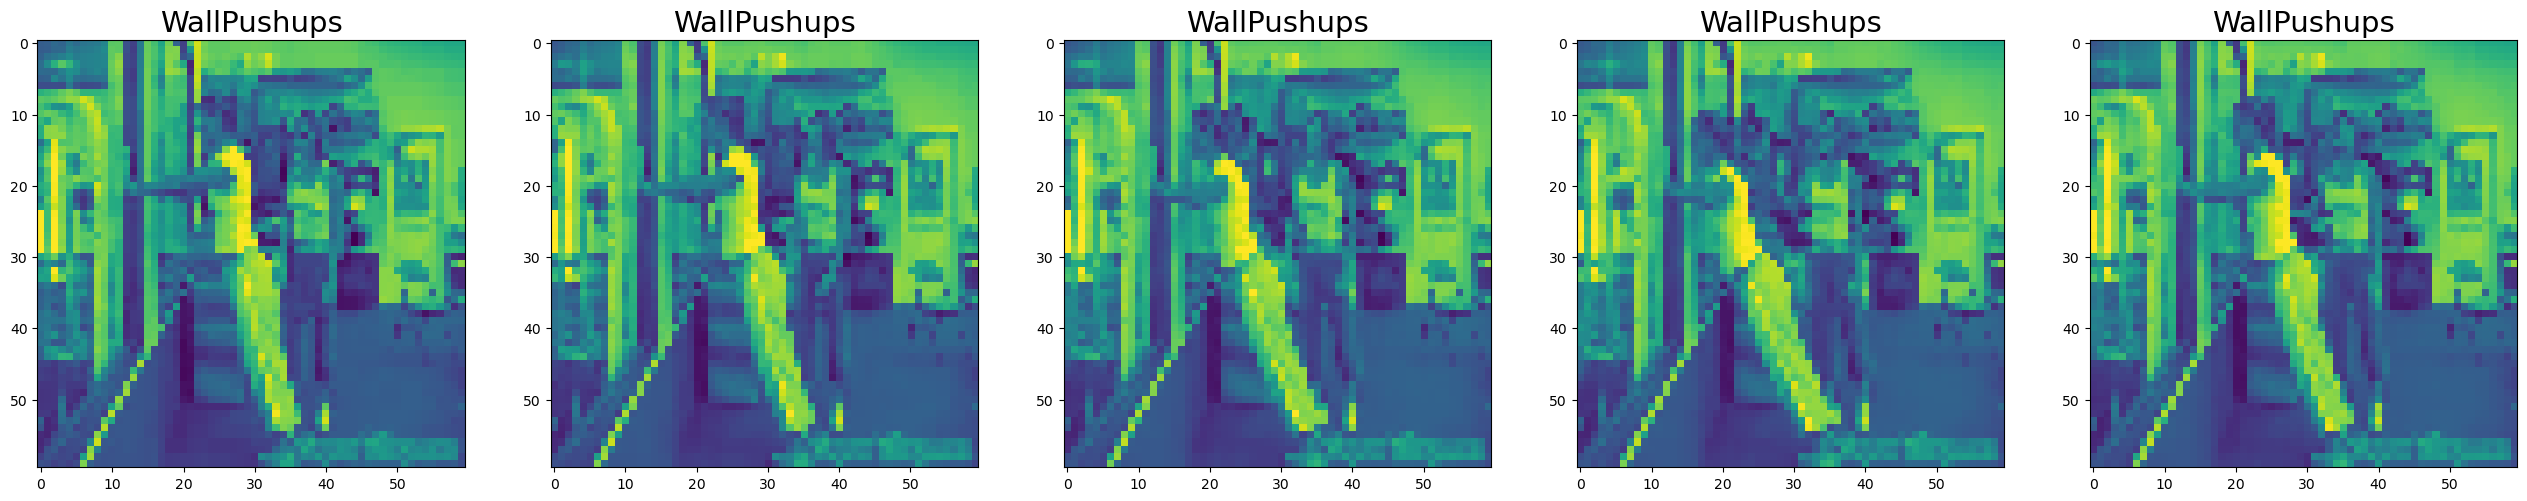

In [9]:
random_video_index = np.random.randint(0,len(images))
videoview(random_video_index)

In [10]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [11]:
num_frames = 5  # Çerçeve sayısı
frame_height = 60  # Çerçeve yüksekliği
frame_width = 60   # Çerçeve genişliği
num_channels = 3   # Kanal sayısı
num_classes = 20 

In [12]:
# Model oluşturma
model = Sequential()

# CNN katmanları
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(num_frames, frame_height, frame_width, num_channels)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

# LSTM katmanları
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))  # Son LSTM katmanı return_sequences=False ile sona erer

# Tam bağlantılı (Dense) katmanlar
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))  # 20 sınıf için çıkış katmanı

# Modeli derleme
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model özetini görüntüle
model.summary()


2023-09-22 15:19:01.043811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 15:19:01.059666: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-22 15:19:01.059796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 58, 58, 32)     896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 29, 29, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 27, 27, 64)     18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 13, 13, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 11, 11, 128)    7

In [13]:
class_weight = Counter(y_train)
class_weight

Counter({11: 124,
         6: 118,
         5: 111,
         18: 147,
         2: 139,
         7: 122,
         4: 109,
         1: 105,
         16: 114,
         14: 94,
         17: 126,
         8: 136,
         13: 125,
         9: 90,
         10: 154,
         19: 117,
         12: 110,
         15: 109,
         3: 130,
         0: 91})

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
model.fit(x_train, y_train, epochs=25)

Epoch 1/25


2023-09-22 15:19:08.016416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 15:19:08.095154: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 15:19:08.095711: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 15:19:08.095721: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-09-22 15:19:08.096391: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-22 15:19:08.096467: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

InternalError: Graph execution error:

Detected at node 'Adam/StatefulPartitionedCall_15' defined at (most recent call last):
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_20169/2090947011.py", line 1, in <module>
      model.fit(x_train, y_train, epochs=25)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1260, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1352, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/muhlabws4/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1347, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'Adam/StatefulPartitionedCall_15'
libdevice not found at ./libdevice.10.bc
	 [[{{node Adam/StatefulPartitionedCall_15}}]] [Op:__inference_train_function_6811]